In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## how Severity the Accidents is ?

In [5]:
# Files to laod
#accident_data= "DataFile/mock_accident_data.csv"
accident_data= "DataFile/US_Accidents_Dec21_updated.csv"
#accident_data="https://umausdata.s3.amazonaws.com/DataFile/mock_accident_data.csv"
accident_df=pd.read_csv(accident_data)

In [6]:
accident_df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [7]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Number                 float64
 11  Street                 object 
 12  Side                   object 
 13  City                   object 
 14  County                 object 
 15  State                  object 
 16  Zipcode                object 
 17  Country                object 
 18  Timezone               object 
 19  Airport_Code           object 
 20  Weather_Timestamp      object 
 21  Temperature(F)         float64
 22  Wind_Chill(F)     

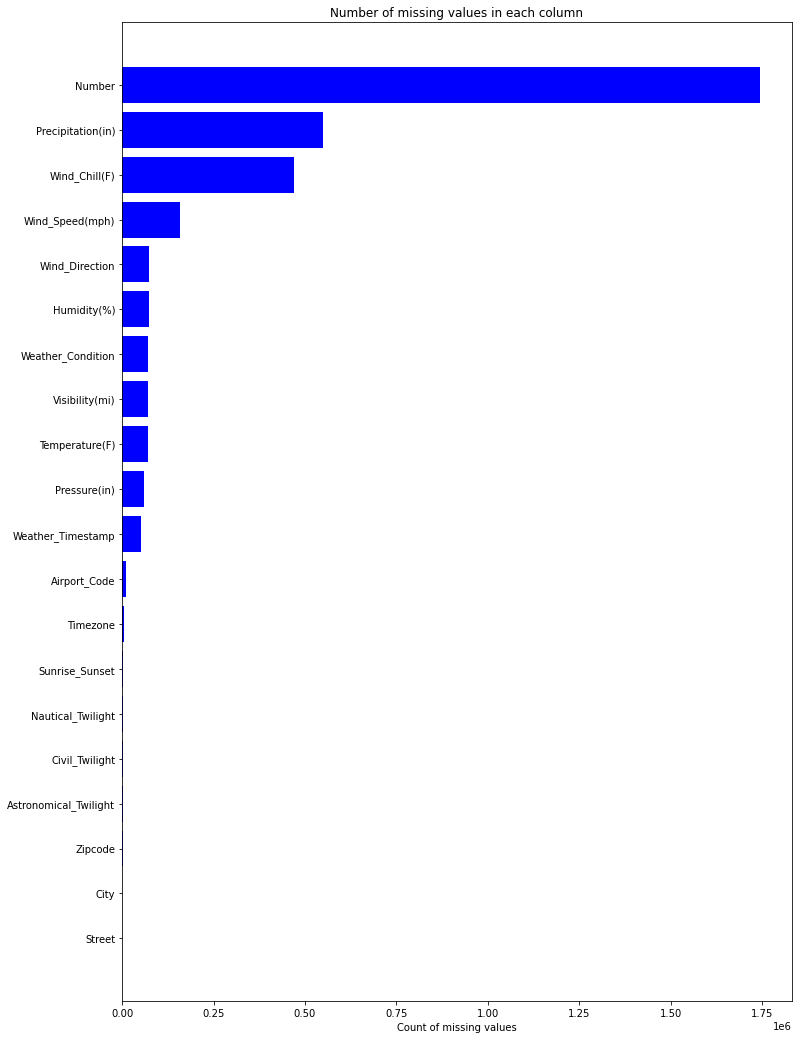

In [8]:
missing_df = accident_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [9]:
#Drop the null columns where all values are null
accident_df=accident_df.dropna(axis='columns',how='all')

In [10]:
accident_df.shape

(2845342, 47)

In [11]:
accident_df['Start_Time'] = pd.to_datetime(accident_df['Start_Time'])

In [12]:
#accident_df['year'] = pd.DatetimeIndex(accident_df['Start_Time']).year
accident_df['Month'] = pd.DatetimeIndex(accident_df['Start_Time']).month
accident_df['Day'] = pd.to_datetime(accident_df['Start_Time']).dt.day_name()
accident_df['Hour'] = pd.to_datetime(accident_df['Start_Time']).dt.hour

In [13]:
accident_df['End_Time'] = pd.to_datetime(accident_df['End_Time'])

In [14]:
# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
accident_df[td]=round((accident_df['End_Time']-accident_df['Start_Time'])/np.timedelta64(1,'m'))

In [15]:
neg_outliers=accident_df[td]<=0

# Set outliers to NAN
accident_df[neg_outliers] = np.nan

# Drop rows with negative td
accident_df.dropna(subset=[td],axis=0,inplace=True)

In [16]:
print(accident_df.columns)

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Month', 'Day', 'Hour', 'Time_Duration(min)'],
      dtype='object')


In [17]:
#drop the non-beneficial columns
#accident_df=accident_df.drop(columns=['ID','End_Time','End_Lat','End_Lng','Description','Side','Airport_Code','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight',"Start_Time",'ID','Weather_Timestamp','Zipcode','Street','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Country'])
accident_df=accident_df.drop(columns=['ID','Description','Airport_Code','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Description','Zipcode','Country','Weather_Timestamp','Start_Time','End_Time','Street'])

In [18]:
accident_df.shape

(2845342, 39)

In [19]:
accident_df.dtypes

Severity              float64
Start_Lat             float64
Start_Lng             float64
End_Lat               float64
End_Lng               float64
Distance(mi)          float64
Number                float64
Side                   object
City                   object
County                 object
State                  object
Timezone               object
Temperature(F)        float64
Wind_Chill(F)         float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction         object
Wind_Speed(mph)       float64
Precipitation(in)     float64
Weather_Condition      object
Amenity                object
Bump                   object
Crossing               object
Give_Way               object
Junction               object
No_Exit                object
Railway                object
Roundabout             object
Station                object
Stop                   object
Traffic_Calming        object
Traffic_Signal         object
Turning_Lo

In [20]:
# Determine the number of unique values in each column.
accident_df.nunique()

Severity                    4
Start_Lat             1093618
Start_Lng             1120365
End_Lat               1080811
End_Lng               1105404
Distance(mi)            14165
Number                  46402
Side                        3
City                    11681
County                   1707
State                      49
Timezone                    4
Temperature(F)            788
Wind_Chill(F)             897
Humidity(%)               100
Pressure(in)             1068
Visibility(mi)             76
Wind_Direction             24
Wind_Speed(mph)           136
Precipitation(in)         230
Weather_Condition         127
Amenity                     2
Bump                        2
Crossing                    2
Give_Way                    2
Junction                    2
No_Exit                     2
Railway                     2
Roundabout                  2
Station                     2
Stop                        2
Traffic_Calming             2
Traffic_Signal              2
Turning_Lo

In [21]:
# examine home _ownwrship
#street_count=accident_df['Street'].value_counts()

In [22]:
#list(street_count[street_count<20].index)

In [23]:
# Determine which values to replace if counts are less than ...? less than 20
#replace_street = list(street_count[street_count<20].index)

# Replace in dataframe
#for street in replace_street:
    #accident_df.Street = accident_df.Street.replace(street,"Other")
    
# Check to make sure binning was successful
#accident_df.Street.value_counts()

In [24]:
accident_df=accident_df.drop(columns=[])

In [25]:
accident_df=accident_df.dropna()

In [26]:
# accident_df.to_csv('C:/Users/Helanga/Desktop/THe_Final_Project_Data_Visualization/DataFile/mock_accident_Cleaneddata.csv', sep=',',encoding='utf-8',header='true')

In [27]:
#replace all bollean values to integer
accident_df.replace({False: 0, True: 1}, inplace=True)

In [28]:
accident_df.dtypes

Severity              float64
Start_Lat             float64
Start_Lng             float64
End_Lat               float64
End_Lng               float64
Distance(mi)          float64
Number                float64
Side                   object
City                   object
County                 object
State                  object
Timezone               object
Temperature(F)        float64
Wind_Chill(F)         float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction         object
Wind_Speed(mph)       float64
Precipitation(in)     float64
Weather_Condition      object
Amenity                 int64
Bump                    int64
Crossing                int64
Give_Way                int64
Junction                int64
No_Exit                 int64
Railway                 int64
Roundabout              int64
Station                 int64
Stop                    int64
Traffic_Calming         int64
Traffic_Signal          int64
Turning_Lo

In [29]:
# check Severity column
accident_df['Severity'].value_counts()

2.0    889905
4.0     29073
3.0     13716
1.0     10625
Name: Severity, dtype: int64

#### converting the string values into numerical ones using label encoder

In [30]:
# To see which columns have categorical value columns
X_cat = accident_df.select_dtypes(include='object').columns
X_cat

Index(['Side', 'City', 'County', 'State', 'Timezone', 'Wind_Direction',
       'Weather_Condition', 'Sunrise_Sunset', 'Day'],
      dtype='object')

In [31]:
# examine all the columns
for column in accident_df[X_cat]:
    print(column,"\n", accident_df[column].value_counts())
    print("--------------------------------------")

Side 
 R    528173
L    415146
Name: Side, dtype: int64
--------------------------------------
City 
 Miami                           67276
Orlando                         37644
Los Angeles                     20194
Houston                         18923
Charlotte                       16044
                                ...  
Asbury                              1
Prestonsburg                        1
Marble                              1
Intervale                           1
American Fork-Pleasant Grove        1
Name: City, Length: 8504, dtype: int64
--------------------------------------
County 
 Miami-Dade     93684
Los Angeles    51695
Orange         48003
Montgomery     20955
Harris         19302
               ...  
LaSalle            1
Moniteau           1
Woodford           1
Gregg              1
Ness               1
Name: County, Length: 1411, dtype: int64
--------------------------------------
State 
 FL    217566
CA    215629
SC     57482
TX     52073
PA     48470
OR     45

In [32]:
from sklearn.preprocessing import LabelEncoder
#
# Instantiate LabelEncoder
#
le = LabelEncoder()


In [33]:
# Encode single column Side
#
#accident_df.Street = le.fit_transform(accident_df.Street)
#
# Print df.head for checking the transformatio

In [34]:
#accident_df['Street']

In [35]:
#print(accident_df['Street'].nunique())

In [36]:
# Encode single column Side
#
accident_df.Side = le.fit_transform(accident_df.Side)
#
# Print df.head for checking the transformation

In [37]:
accident_df['Side']

42         1
43         1
47         1
50         0
66         0
          ..
2845298    1
2845302    1
2845303    1
2845304    0
2845307    1
Name: Side, Length: 943319, dtype: int32

In [38]:
# Encode single column City
#
accident_df.City = le.fit_transform(accident_df.City)
#
# Print df.head for checking the transformation

In [39]:
accident_df['City']

42         2051
43         6318
47         8311
50         1033
66         1429
           ... 
2845298    5727
2845302    8477
2845303    8477
2845304    6718
2845307    2913
Name: City, Length: 943319, dtype: int32

In [40]:
#accident_df['City'].unique().value_counts
print(accident_df['City'].nunique())

8504


In [41]:
# Encode single column County
#
accident_df.County = le.fit_transform(accident_df.County)
#
# Print df.head for checking the transformation

In [42]:
accident_df['County']

42          632
43          632
47         1304
50          316
66          333
           ... 
2845298    1121
2845302    1235
2845303    1235
2845304    1115
2845307    1127
Name: County, Length: 943319, dtype: int32

In [43]:
print(accident_df['County'].nunique())

1411


In [44]:
# Encode single column State
#
accident_df.State = le.fit_transform(accident_df.State)
#
# Print df.head for checking the transformation

In [45]:
accident_df['State']

42         13
43         13
47         33
50         36
66         33
           ..
2845298     3
2845302     3
2845303     3
2845304     3
2845307     3
Name: State, Length: 943319, dtype: int32

In [46]:
# Encode single column Timezone 
#
accident_df.Timezone  = le.fit_transform(accident_df.Timezone)
#
# Print df.head for checking the transformation

In [47]:
accident_df['Timezone']

42         1
43         1
47         1
50         1
66         1
          ..
2845298    3
2845302    3
2845303    3
2845304    3
2845307    3
Name: Timezone, Length: 943319, dtype: int32

In [48]:
# Encode single column Wind_Direction 
#
accident_df.Wind_Direction  = le.fit_transform(accident_df.Wind_Direction)
#
# Print df.head for checking the transformation

In [49]:
accident_df['Wind_Direction']

42         20
43         20
47         22
50         21
66         22
           ..
2845298     7
2845302    11
2845303    11
2845304    19
2845307    17
Name: Wind_Direction, Length: 943319, dtype: int32

In [50]:
# Encode single column Weather_Condition 
#
accident_df.Weather_Condition  = le.fit_transform(accident_df.Weather_Condition)
#
# Print df.head for checking the transformation

In [51]:
accident_df['Weather_Condition']

42         45
43         45
47         45
50         45
66         45
           ..
2845298    10
2845302    56
2845303    56
2845304    10
2845307     5
Name: Weather_Condition, Length: 943319, dtype: int32

In [52]:
# Encode single column Sunrise_Sunset 
#
accident_df.Sunrise_Sunset  = le.fit_transform(accident_df.Sunrise_Sunset)
#
# Print df.head for checking the transformation

In [53]:
accident_df['Sunrise_Sunset']

42         1
43         1
47         1
50         0
66         0
          ..
2845298    0
2845302    0
2845303    0
2845304    1
2845307    0
Name: Sunrise_Sunset, Length: 943319, dtype: int32

In [54]:
# Encode single column Day 
#
accident_df.Day  = le.fit_transform(accident_df.Day)
#
# Print df.head for checking the transformation

In [55]:
accident_df['Day']

42         5
43         5
47         6
50         6
66         6
          ..
2845298    0
2845302    0
2845303    0
2845304    0
2845307    0
Name: Day, Length: 943319, dtype: int32

In [56]:
accident_df.dtypes

Severity              float64
Start_Lat             float64
Start_Lng             float64
End_Lat               float64
End_Lng               float64
Distance(mi)          float64
Number                float64
Side                    int32
City                    int32
County                  int32
State                   int32
Timezone                int32
Temperature(F)        float64
Wind_Chill(F)         float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction          int32
Wind_Speed(mph)       float64
Precipitation(in)     float64
Weather_Condition       int32
Amenity                 int64
Bump                    int64
Crossing                int64
Give_Way                int64
Junction                int64
No_Exit                 int64
Railway                 int64
Roundabout              int64
Station                 int64
Stop                    int64
Traffic_Calming         int64
Traffic_Signal          int64
Turning_Lo

#### Split the Data into Training and Testing

In [57]:
# Create our features
X = accident_df.drop("Severity",axis=1) 
X.head()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Side,City,County,State,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Month,Day,Hour,Time_Duration(min)
42,40.45112,-85.15048,40.35429,-85.14993,6.690,9001.0,1,2051,632,13,...,0,0,0,0,0,1,2.0,5,18.0,360.0
43,40.35429,-85.14993,40.45112,-85.15048,6.690,473.0,1,6318,632,13,...,0,0,0,0,0,1,2.0,5,18.0,360.0
47,40.72813,-84.78965,40.74559,-84.78962,1.206,12998.0,1,8311,1304,33,...,0,0,0,0,0,1,2.0,6,6.0,360.0
50,41.83193,-80.10143,41.84149,-80.11099,0.824,25529.0,0,1033,316,36,...,0,0,0,0,0,0,2.0,6,8.0,360.0
66,41.48339,-81.66297,41.47692,-81.66075,0.462,3937.0,0,1429,333,33,...,0,0,0,0,0,0,2.0,6,12.0,360.0


In [58]:
X.describe()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Side,City,County,State,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Month,Day,Hour,Time_Duration(min)
count,943319.000000,943319.000000,943319.000000,943319.000000,943319.000000,9.433190e+05,943319.000000,943319.000000,943319.000000,943319.000000,...,943319.000000,943319.000000,943319.000000,943319.000000,943319.0,943319.000000,943319.000000,943319.000000,943319.000000,943319.000000
mean,35.069960,-95.102555,35.070232,-95.102258,0.274626,7.924180e+03,0.559909,4367.526769,773.522960,18.620370,...,0.050687,0.036233,0.001007,0.136188,0.0,0.368202,7.894550,3.005323,13.116501,253.481295
std,5.796631,17.794338,5.796704,17.794093,0.883254,1.838707e+04,0.496398,2297.616253,331.079789,15.016266,...,0.219358,0.186869,0.031719,0.342989,0.0,0.482317,3.580055,2.103581,5.828700,5077.800324
min,24.566027,-124.517744,24.566013,-124.509263,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,5.000000
25%,30.229959,-117.833326,30.230207,-117.833756,0.040000,1.274000e+03,0.000000,2537.000000,553.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.000000,1.000000,9.000000,77.000000
50%,34.976102,-86.136779,34.976489,-86.137770,0.111000,4.001000e+03,1.000000,4796.000000,820.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.000000,3.000000,14.000000,120.000000
75%,39.232680,-80.359478,39.232685,-80.358917,0.255000,9.467000e+03,1.000000,6249.000000,992.000000,35.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,11.000000,5.000000,17.000000,162.000000
max,48.996539,-67.484130,48.998144,-67.484130,112.968000,9.999997e+06,1.000000,8503.000000,1410.000000,48.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,12.000000,6.000000,23.000000,961379.000000


In [59]:
#Create our target
y = accident_df['Severity']
y.value_counts()

2.0    889905
4.0     29073
3.0     13716
1.0     10625
Name: Severity, dtype: int64

In [60]:
# examine shape of X

X.shape

(943319, 38)

In [61]:
y.shape

(943319,)

#### Split encoded Data into Training and Testing

In [62]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 1)

In [63]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

###### Standered Scaler to scale data

In [64]:
#from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
#scaler = StandardScaler()

# Fit the StandardScaler
#X_scaler = scaler.fit(X_train)

# Scale the data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [65]:
y_train.value_counts()

2.0    667409
4.0     21848
3.0     10314
1.0      7918
Name: Severity, dtype: int64

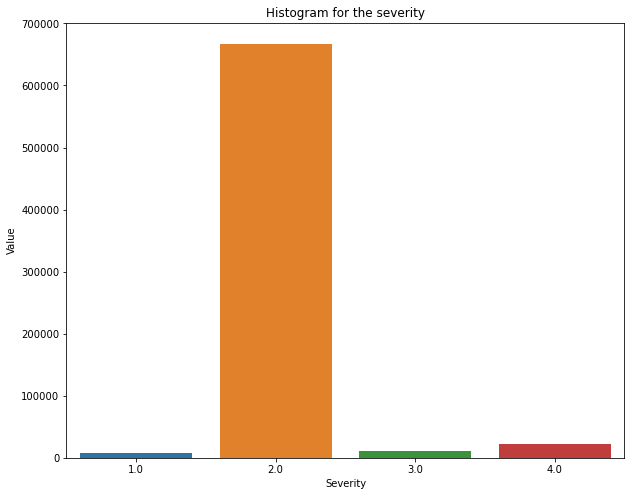

In [66]:
# imbalanced data set
import matplotlib.pyplot 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

severity_counts = y_train.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

### Oversampling
###### In this section, compared two oversampling algorithms to determine which algorithm results in the best performance.And oversampled the data using the naive random oversampling algorithm and the SMOTE algorithm. 


#### Naive Random Oversampling

In [68]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
#X_resampled,y_resampled =ros.fit_resample(X_train_scaled,y_train)
X_resampled,y_resampled =ros.fit_resample(X_train,y_train)

In [69]:
# what is the "balance" or mix between Severity
Counter(y_resampled)

Counter({2.0: 667409, 4.0: 667409, 1.0: 667409, 3.0: 667409})

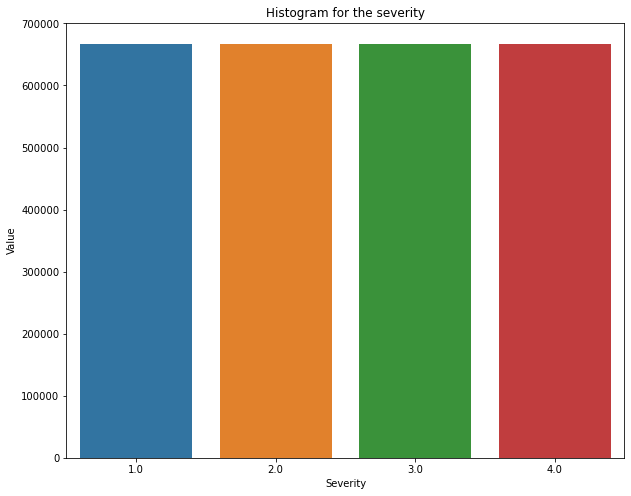

In [70]:
severity_counts = y_resampled.value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(severity_counts.index, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [71]:
# Train the Logistic Regression model using the resampled data
#model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X_resampled,y_resampled)
#predict using the predict method
y_pred = clf.predict(X_test)

In [72]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test,y_pred)

0.4617083760293368

In [73]:
# Display the confusion matrix
cm = confusion_matrix(y_test,y_pred,labels=clf.classes_)
cm

array([[ 2037,    79,   552,    39],
       [21705, 90652, 73189, 36950],
       [ 1463,   225,  1373,   341],
       [ 1664,  1254,  2260,  2047]], dtype=int64)

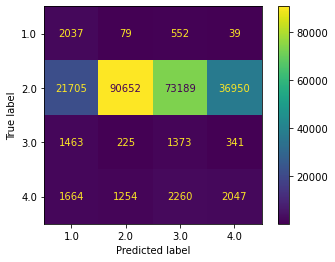

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= clf.classes_)
disp.plot()

In [75]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.08      0.75      0.89      0.14      0.82      0.66      2707
        2.0       0.98      0.41      0.88      0.58      0.60      0.34    222496
        3.0       0.02      0.40      0.67      0.03      0.52      0.26      3402
        4.0       0.05      0.28      0.84      0.09      0.49      0.22      7225

avg / total       0.93      0.41      0.88      0.55      0.60      0.34    235830



#### Ensemble Learners
###### In this section,  compared two ensemble algorithms to determine which algorithm results in the best performance. trained a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier .

#### Balanced Random Forest Classifier

In [76]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [77]:
# Resample the training data with the BalancedRandomForestClassifier

#model
brf_model = BalancedRandomForestClassifier(random_state=1, n_estimators=100)
#fit
#brf_model = brf_model.fit(X_train_scaled, y_train)

brf_model = brf_model.fit(X_train, y_train)
#predict
predictions = brf_model.predict(X_test)

In [78]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test,predictions)


0.8624535928679388

In [79]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1","Actual 2", "Actual 3"], columns=["Predicted 0", "Predicted 1","Predicted 2", "Predicted 3"])

cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,2563,5,108,31
Actual 1,3039,186189,9146,24122
Actual 2,215,56,2822,309
Actual 3,105,672,403,6045


In [80]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.43      0.95      0.99      0.59      0.97      0.93      2707
        2.0       1.00      0.84      0.95      0.91      0.89      0.78    222496
        3.0       0.23      0.83      0.96      0.36      0.89      0.78      3402
        4.0       0.20      0.84      0.89      0.32      0.86      0.74      7225

avg / total       0.95      0.84      0.94      0.88      0.89      0.78    235830



In [81]:
# We can sort the features by their importance.
sorted (zip(brf_model.feature_importances_,X.columns),reverse=True)

[(0.14885699279072115, 'Distance(mi)'),
 (0.1313910142115974, 'Time_Duration(min)'),
 (0.07393241093839359, 'Start_Lat'),
 (0.06858770794147913, 'End_Lat'),
 (0.06667689720977885, 'End_Lng'),
 (0.06460060387491633, 'Start_Lng'),
 (0.05577723504953518, 'Month'),
 (0.04924539005362143, 'State'),
 (0.03907290224063054, 'Pressure(in)'),
 (0.029535000132104444, 'County'),
 (0.0258657965263429, 'Number'),
 (0.025760000937639648, 'City'),
 (0.025147955988698182, 'Timezone'),
 (0.025125488190040145, 'Humidity(%)'),
 (0.023519942442245517, 'Temperature(F)'),
 (0.022697789950915186, 'Wind_Chill(F)'),
 (0.022164570361060423, 'Hour'),
 (0.015951921347184272, 'Wind_Speed(mph)'),
 (0.015448398037099619, 'Wind_Direction'),
 (0.014487219792759055, 'Traffic_Signal'),
 (0.012543396480559518, 'Day'),
 (0.011154278533379634, 'Weather_Condition'),
 (0.008426008121058004, 'Crossing'),
 (0.005750272045432845, 'Visibility(mi)'),
 (0.004966278039927395, 'Sunrise_Sunset'),
 (0.004224033224034819, 'Side'),
 (0.0

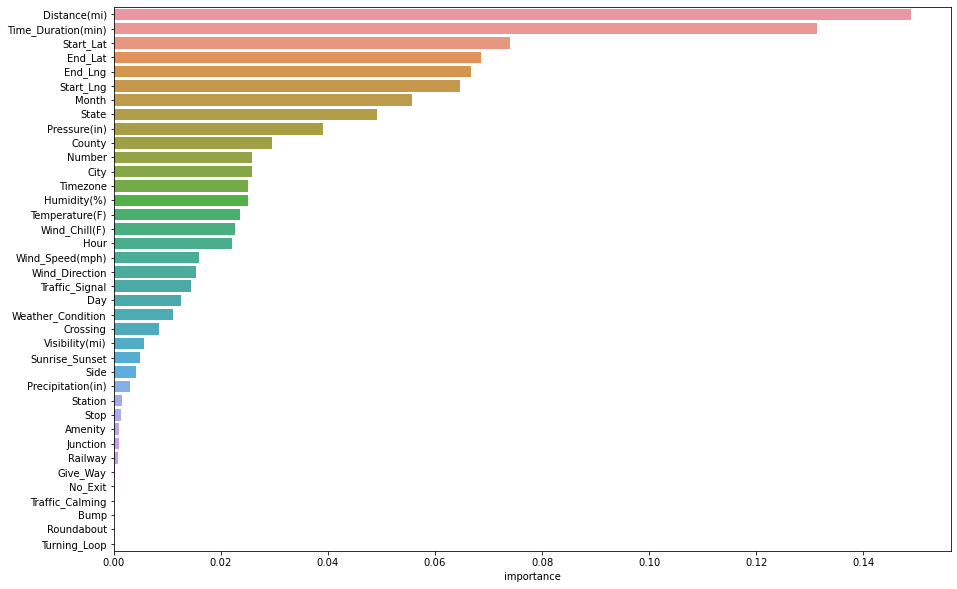

In [82]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = brf_model.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:40]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()